In [57]:
import pandas as pd
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# sklearn vectorizers 
from sklearn.feature_extraction.text import TfidfVectorizer

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# visualizations 
import seaborn as sns 
import plotly.express as px

In [3]:
# our processed dataset and corpus with all our lemmatized tokens 
spotify_df = pd.read_csv('data/preprocessed-reviews.csv')
corpus = pd.read_csv('data/spotify-reviews.csv')

In [4]:
# our tokenized wordsfrom preprocessed data
# we'll need to rename our column to prevent future confusion
corpus = corpus.rename(columns={'review':'tokens'})
corpus.head()

,tokens
0,great music service audio high quality app eas...
1,please ignore previous negative rating app sup...
2,get best spotify experience android annoy plea...
3,really buggy terrible use recently
4,dear spotify get song put playlist shuffle play


In [5]:
# our cleaned dataset with sentiment labels
spotify_df.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos


## EDA 

### Class Imbalance 

<Axes: xlabel='sentiment', ylabel='Count'>

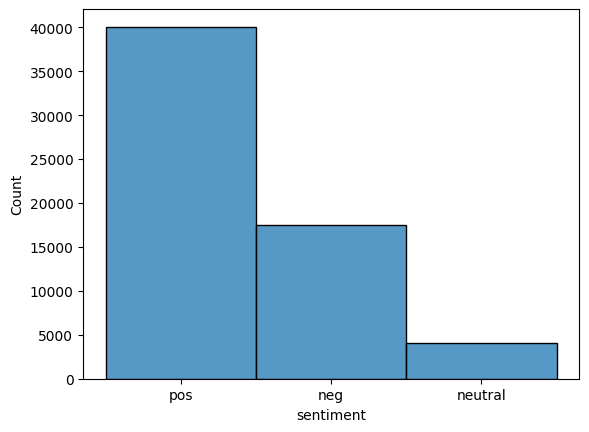

In [6]:
# since we are building a binary sentiment analysis classifier, need to look at class imbalance 
sns.histplot(x='sentiment', data=spotify_df)

### Correlation Matrix with all Numeric Features

In [129]:
# correlation between numeric features 
spotify_df.corr(numeric_only=True)

,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score
rating,1.000000,-0.023966,-0.026375,0.558610,0.589197,-0.418237
total_thumbs_up,-0.023966,1.000000,0.006902,0.004895,-0.032150,0.003423
replied,-0.026375,0.006902,1.000000,-0.021207,-0.025088,0.017654
comp_score,0.558610,0.004895,-0.021207,1.000000,0.709050,-0.710155
pos_score,0.589197,-0.032150,-0.025088,0.709050,1.000000,-0.427821
neg_score,-0.418237,0.003423,0.017654,-0.710155,-0.427821,1.000000


### Review Sentiment & Users' Ratings

-  Is there a relationship between users' sentiment and the rating provided?

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


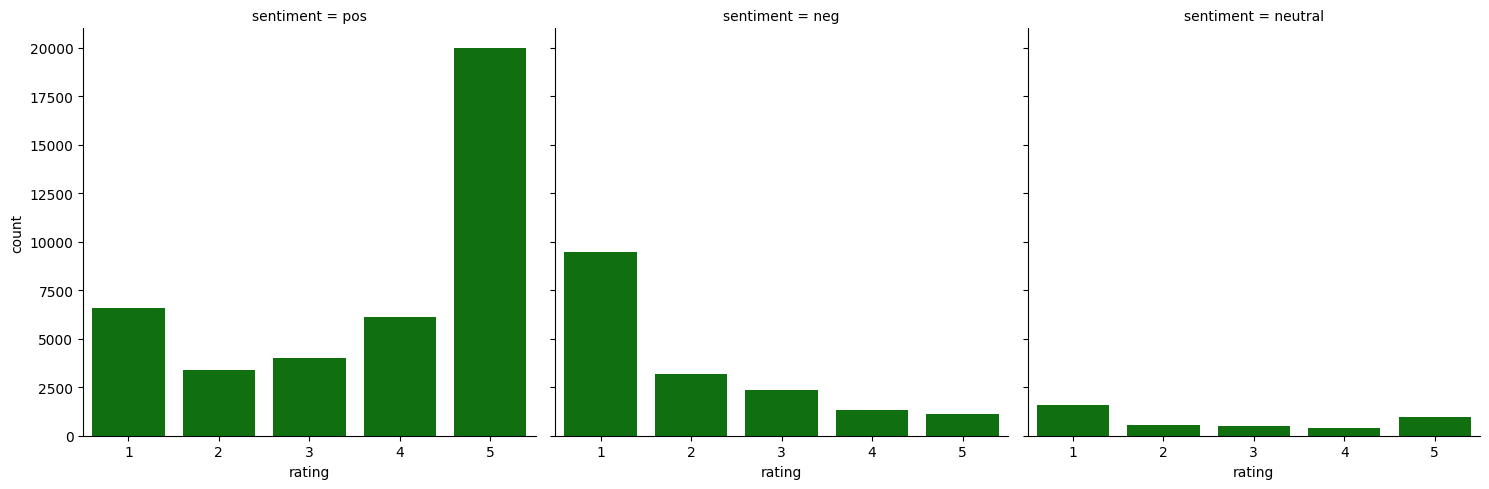

<Figure size 640x480 with 0 Axes>

In [18]:
# seeing the product rating by each sentiment label 
sns.catplot(data=spotify_df,x='rating',kind='count', col='sentiment', color='green')
plt.show()
plt.tight_layout()

Findings: 
- reviews with positive and negative sentiments all have ratings between 1 and 5
- reviews with a 'positive' sentiment have the majority of ratings between 3 and 5, with the median rating being 4 stars 
- reviews with a 'negative' sentiment have the majority of ratings between 1 and 3, with a median score of 1. 

### Relationship between Rating & Service Response

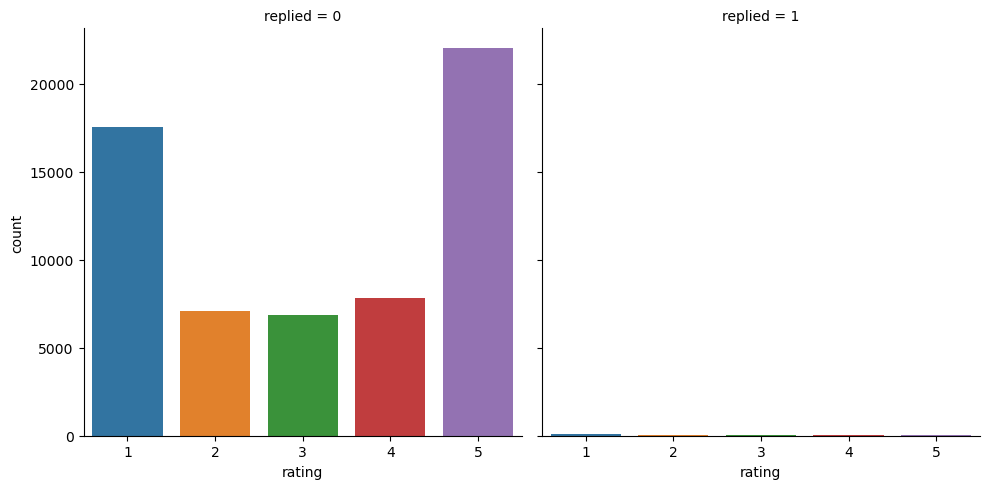

In [109]:
# visualizing the rx between rating and whether spotify replied to review 
sns.catplot(data=spotify_df,x='rating',kind='count', col='replied')
plt.show()

### Distribution of App Ratings

<Axes: xlabel='rating', ylabel='count'>

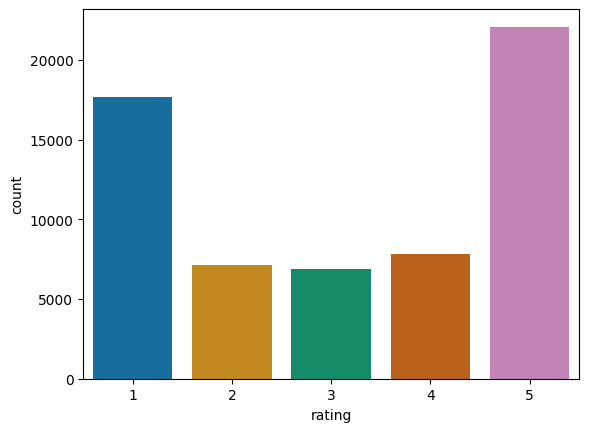

In [288]:
# a handy count plot 
sns.countplot(data=spotify_reviews,x='rating',palette='colorblind')

## WordClouds

### Generating WordClouds for Positive & Negative Reviews 

For our analysis, we'll want to create a visual representation of words that are in positive and negative sentiment reviews. To do so, we'll use `TfidfVectorizer` to extract words that are important. 

We'll need to concatenate our two dataframes so that we have a way to create a dataframe containing only positive and negative sentiment reviews as well as their tokenized words.

In [21]:
# concatenating our two dataframes 
spotify_reviews = pd.concat([spotify_df,corpus], axis=1)

# visually inspecting it
spotify_reviews.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play


In [316]:
spotify_reviews.sentiment.value_counts(normalize=True)

pos        0.650469
neg        0.284248
neutral    0.065282
Name: sentiment, dtype: float64

Now, we have our complete dataframe with our sentiment labels and the lemmatized tokens for each review. Time to extract only the positive and negative reviews!

In [269]:
reviews_positive = spotify_reviews[(spotify_reviews.sentiment.str.contains('pos')) & (spotify_reviews.rating > 3)]
reviews_negative = spotify_reviews[(spotify_reviews.sentiment.str.contains('neg')) & (spotify_reviews.rating < 3)]
reviews_neutral = spotify_reviews[(spotify_reviews.sentiment.str.contains('neutral')) & (spotify_reviews.rating == 3)]
len(reviews_positive) + len(reviews_negative) + len(reviews_neutral)

39296

In [292]:
tester = spotify_reviews.iloc[4].review

In [293]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [298]:
sent_analyzer = SentimentIntensityAnalyzer()

In [299]:
sent_analyzer.polarity_scores(tester)

{'neg': 0.0, 'neu': 0.74, 'pos': 0.26, 'compound': 0.7149}

In [301]:
TextBlob(tester).sentiment.polarity

0.0

In [302]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [313]:
tester_df = pd.DataFrame(data=spotify_df.review)
tester_df['blob_sentiment'] = tester_df.review.apply(get_polarity)
tester_df['Sentiment_Type']=''
tester_df.loc[tester_df.blob_sentiment>0,'Sentiment_Type']='POSITIVE'
tester_df.loc[tester_df.blob_sentiment==0,'Sentiment_Type']='NEUTRAL'
tester_df.loc[tester_df.blob_sentiment<0,'Sentiment_Type']='NEGATIVE'
tester_df

,review,blob_sentiment,Sentiment_Type
0,"great music service, the audio is high quality...",0.440333,POSITIVE
1,please ignore previous negative rating. this a...,0.166667,POSITIVE
2,"this pop-up ""get the best spotify experience o...",0.100000,POSITIVE
3,really buggy and terrible to use as of recently,-0.266667,NEGATIVE
4,dear spotify why do i get songs that i didn't ...,0.000000,NEUTRAL
...,...,...,...
61589,even though it was communicated that lyrics fe...,0.225000,POSITIVE
61590,"use to be sooo good back when i had it, and wh...",0.400000,POSITIVE
61591,this app would be good if not for it taking ov...,-0.160185,NEGATIVE
61592,the app is good hard to navigate and won't jus...,0.352083,POSITIVE


<Axes: >

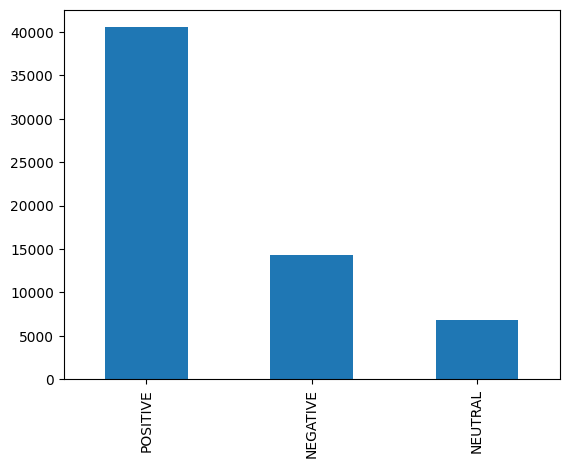

In [320]:
tester_df.Sentiment_Type.value_counts().plot(kind='bar')

In [22]:
# creating separate dataframes for positive and negative reviews using the sentiment labels 
pos_reviews = spotify_reviews[spotify_reviews.sentiment.str.contains('pos')]
neg_reviews = spotify_reviews[spotify_reviews.sentiment.str.contains('neg')]

In [132]:
pos_reviews.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,tokens
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play
6,i love the selection and the lyrics are provid...,5,0,0,0.6696,0.257,0.000,pos,love selection lyric provide song listening


We've created a dataframe for only positive and negative reviews. Now, to better visualize our tokens (which contain words) and determine which are important, we'll use `TfidfVectorizer` to assign weights, cut words that appear too frequently or are too rare, and plot a WordCloud! 

In [140]:
# instantiating our vectorizer 
tfidf_vect = TfidfVectorizer(min_df=0.05,max_df=0.95)

# transforming our positive review tokens 
# this creates a sparse matrix which we will need to densify later 
pos_rv_words = tfidf_vect.fit_transform(pos_reviews.tokens)

In [145]:
# creating a tfidf matrix 
# getting the words from our vectorizer (features)
pos_words = tfidf_vect.get_feature_names_out()

# taking our transformed sparse matrix and creating a dataframe 
pos_wrd_lst = pos_rv_words.todense().tolist()
pos_rv_df = pd.DataFrame(pos_wrd_lst,columns=pos_words)

# each row represents a review 
# each column represents a token and the values are weights assigned by TFIDF
pos_rv_df.head()

,ad,add,also,app,best,easy,even,find,fix,free,...,really,song,spotify,stop,time,update,use,want,well,work
0,0.0,0.0,0.529417,0.252257,0.000000,0.528355,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.386724,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.292825,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.398659,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.288128,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.350841,0.396269,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.619118,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


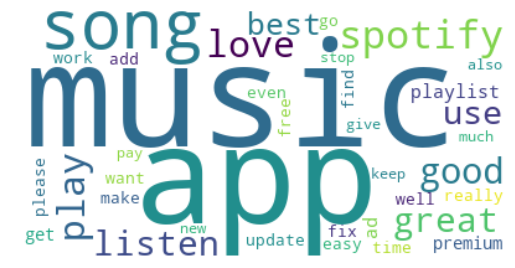

In [215]:
# time to generate our WordCloud! 
pos_wrd_freq = pos_rv_df.T.sum(axis=1)

# instantiating our WordCloud function
wordcloud = WordCloud(background_color='white')

# generating our WordCloud from our Tfidf matrix 
wordcloud.generate_from_frequencies(pos_wrd_freq)

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [212]:
def show_wordcloud(text):
    # instantiating our vectorizer 
    tfidf_vect = TfidfVectorizer(min_df=0.05,max_df=0.95)

    # transforming our positive review tokens 
    # this creates a sparse matrix which we will need to densify later 
    toks_transformed = tfidf_vect.fit_transform(text.tokens)

    # creating a tfidf matrix 
    # getting the words from our vectorizer (features)
    rv_words = tfidf_vect.get_feature_names_out()

    # taking our transformed sparse matrix and creating a dataframe 
    rv_wrd_list = toks_transformed.todense().tolist()
    rv_df = pd.DataFrame(rv_wrd_list, columns=rv_words)
    
    # time to generate our WordCloud! 
    rv_wrd_freq = rv_df.T.sum(axis=1)

    # instantiating our WordCloud function
    wordcloud = WordCloud(background_color='white')

    # generating our WordCloud from our Tfidf matrix 
    wordcloud.generate_from_frequencies(rv_wrd_freq)
    
    # time to show our WordCloud! 
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return 

### Testing Wordcloud with Noun Phrases

In [20]:
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [165]:
custom_stopwrds = list(STOPWORDS) + ['app','spotify','i','dont']

In [90]:
pos_text = str(pos_reviews.review.to_list())
pos_text = pos_text.replace("\'","").replace("[","").replace("]","")
type(pos_text)

str

In [152]:
import random
a1 = random.sample(a, 1000)
type(a1)

list

In [153]:
a = pos_reviews.review.to_list()
#b = a[0:100]
#c = str(b).replace("\'","").replace("[","").replace("]","")
d = str(a1).replace("\'","").replace("[","").replace("]","")

In [154]:
#c

In [155]:
pos_rvs_blob = TextBlob(d)
noun_phrases = pos_rvs_blob.noun_phrases

In [156]:
noun_list = []
for noun in noun_phrases:
    noun_list.append(noun.replace(' ','_'))
#noun_list

In [157]:
noun_str = ' '.join(noun_list)
#print(noun_str)

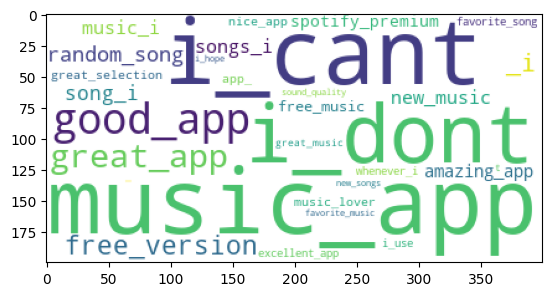

In [234]:
wc = WordCloud(max_words=30,stopwords=custom_stopwrds,background_color='white')
wc.generate(noun_str)
plt.imshow(wc)

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

In [317]:
vec = CountVectorizer(ngram_range=(2,2),min_df=.01,max_df=.85,stop_words=custom_stopwrds)
BOW_1 = vec.fit_transform(pos_reviews.tokens).toarray()
columns = vec.get_feature_names_out()
pos_df = pd.DataFrame(data=BOW_1, columns=columns)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [229]:
pos_freq = pos_df.T.sum(axis=1)

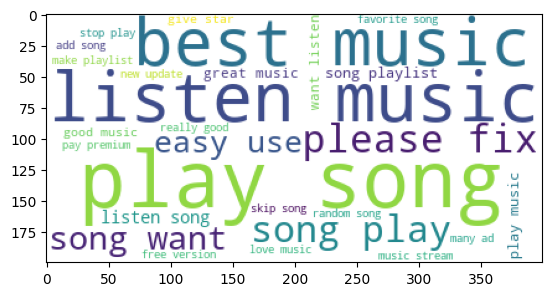

In [235]:
wc.generate_from_frequencies(pos_freq)
plt.imshow(wc)

### TOPIC MODELING - POSITIVE FEATURES (BIGRAM)

In [412]:
pos_X = vec.fit_transform(pos_reviews.tokens)

In [413]:
pos_model = NMF(n_components=4,random_state=42)
pos_model.fit(pos_X)

NMF(n_components=4, random_state=42)

In [414]:
P_H = pos_model.transform(pos_X)
P_W = pos_model.components_

In [415]:
for index,topic in enumerate(P_W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['listen music', 'want listen', 'best music', 'love music', 'easy use', 'great music', 'good music', 'many ad', 'free version', 'really good', 'favorite song', 'make playlist', 'pay premium', 'give star', 'new update', 'skip song', 'add song', 'song want', 'stop play', 'random song', 'play music', 'please fix', 'song playlist', 'song play', 'play song']


THE TOP 10 WORDS FOR TOPIC #1
['play song', 'listen song', 'add song', 'music stream', 'song playlist', 'song play', 'free version', 'new update', 'stop play', 'skip song', 'love music', 'random song', 'great music', 'favorite song', 'pay premium', 'good music', 'make playlist', 'really good', 'many ad', 'please fix', 'easy use', 'give star', 'play music', 'want listen', 'listen music']


THE TOP 10 WORDS FOR TOPIC #2
['random song', 'play song', 'listen music', 'listen song', 'stop play', 'skip song', 'song play', 'new update', 'please fix', 'favorite song', 'make playlist', 'add song', 'love music', 'ma

In [416]:
for index,topic in enumerate(W_pos):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf_vect.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

NameError: name 'W_pos' is not defined

## TOPIC MODELING POSITIVE REVIEW BIGRAMS

In [420]:
count_vec = CountVectorizer(ngram_range=(2,2),stop_words='english',min_df=0.05,max_df=.95)
bag_of_words = count_vec.fit_transform(text).toarray()
df_output = pd.DataFrame(data=bag_of_words,columns = count_vec.get_feature_names_out())

In [422]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(P_W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 5
count_vec_feature_names = vec.get_feature_names_out()
plot_top_words(P_W, count_vec_feature_names, n_top_words, "Topics in NMF model")

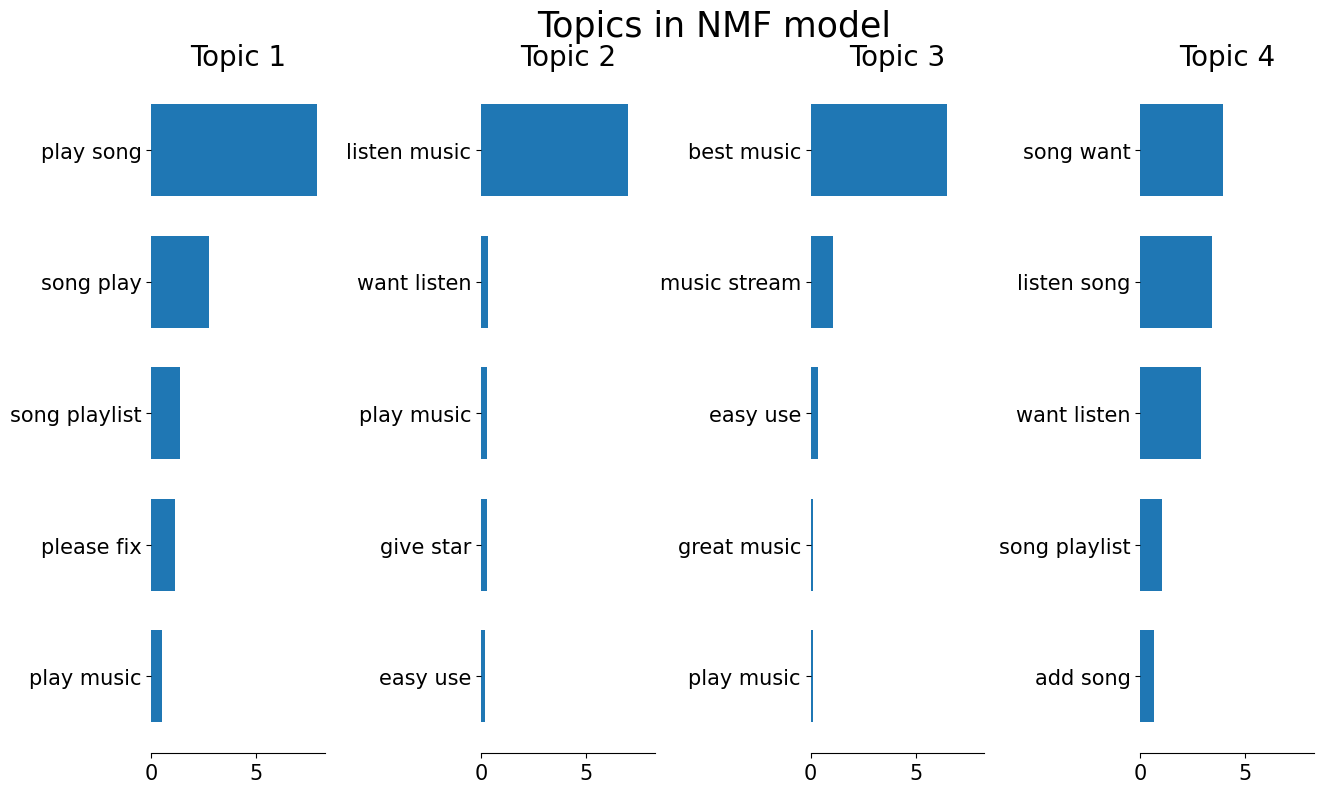

In [423]:
topic_word_plot()

# TOPIC MODELING POSITIVE REVIEW TRIGRAMS

In [372]:
tri_vec = CountVectorizer(ngram_range=(3,3),min_df=.001,max_df=.85,stop_words=custom_stopwrds)
tri_BOW = tri_vec.fit_transform(pos_reviews.tokens).toarray()
tri_columns = tri_vec.get_feature_names_out()
tri_pos_df = pd.DataFrame(data=tri_BOW, columns=tri_columns)

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [373]:
tri_pos_X = tri_vec.fit_transform(pos_reviews.tokens)

In [403]:
tri_pos_model = NMF(n_components=4,random_state=42)
tri_pos_model.fit(tri_pos_X)

NMF(n_components=4, random_state=42)

In [404]:
tri_H = tri_pos_model.transform(tri_pos_X)
tri_W = tri_pos_model.components_

In [424]:
for index,topic in enumerate(tri_W):
    print(f'THE TOP 10 TRIGRAMS FOR TOPIC #{index}')
    print([tri_vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 TRIGRAMS FOR TOPIC #0
['way many ad', 'ad free music', 'start play song', 'song start play', 'play song song', 'add random song', 'listen song ad', 'listen music want', 'keep play song', 'song want hear', 'song playlist play', 'play different song', 'want listen music', 'please fix issue', 'play song want', 'play suggest song', 'find song want', 'add song playlist', 'even listen song', 'song listen song', 'pick song want', 'choose song want', 'want listen song', 'listen song want', 'song want listen']


THE TOP 10 TRIGRAMS FOR TOPIC #1
['please fix problem', 'play favorite song', 'play song play', 'find song want', 'playlist play song', 'please fix bug', 'song playlist play', 'start play song', 'keep play song', 'play song even', 'play song song', 'play specific song', 'song please fix', 'add song playlist', 'song want hear', 'let play song', 'even play song', 'play song playlist', 'play different song', 'song play song', 'pick song want', 'want play song', 'choose song want

In [427]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(tri_W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words =5
count_vec_feature_names = tri_vec.get_feature_names_out()
plot_top_words(P_W, count_vec_feature_names, n_top_words, "Topics in NMF model")

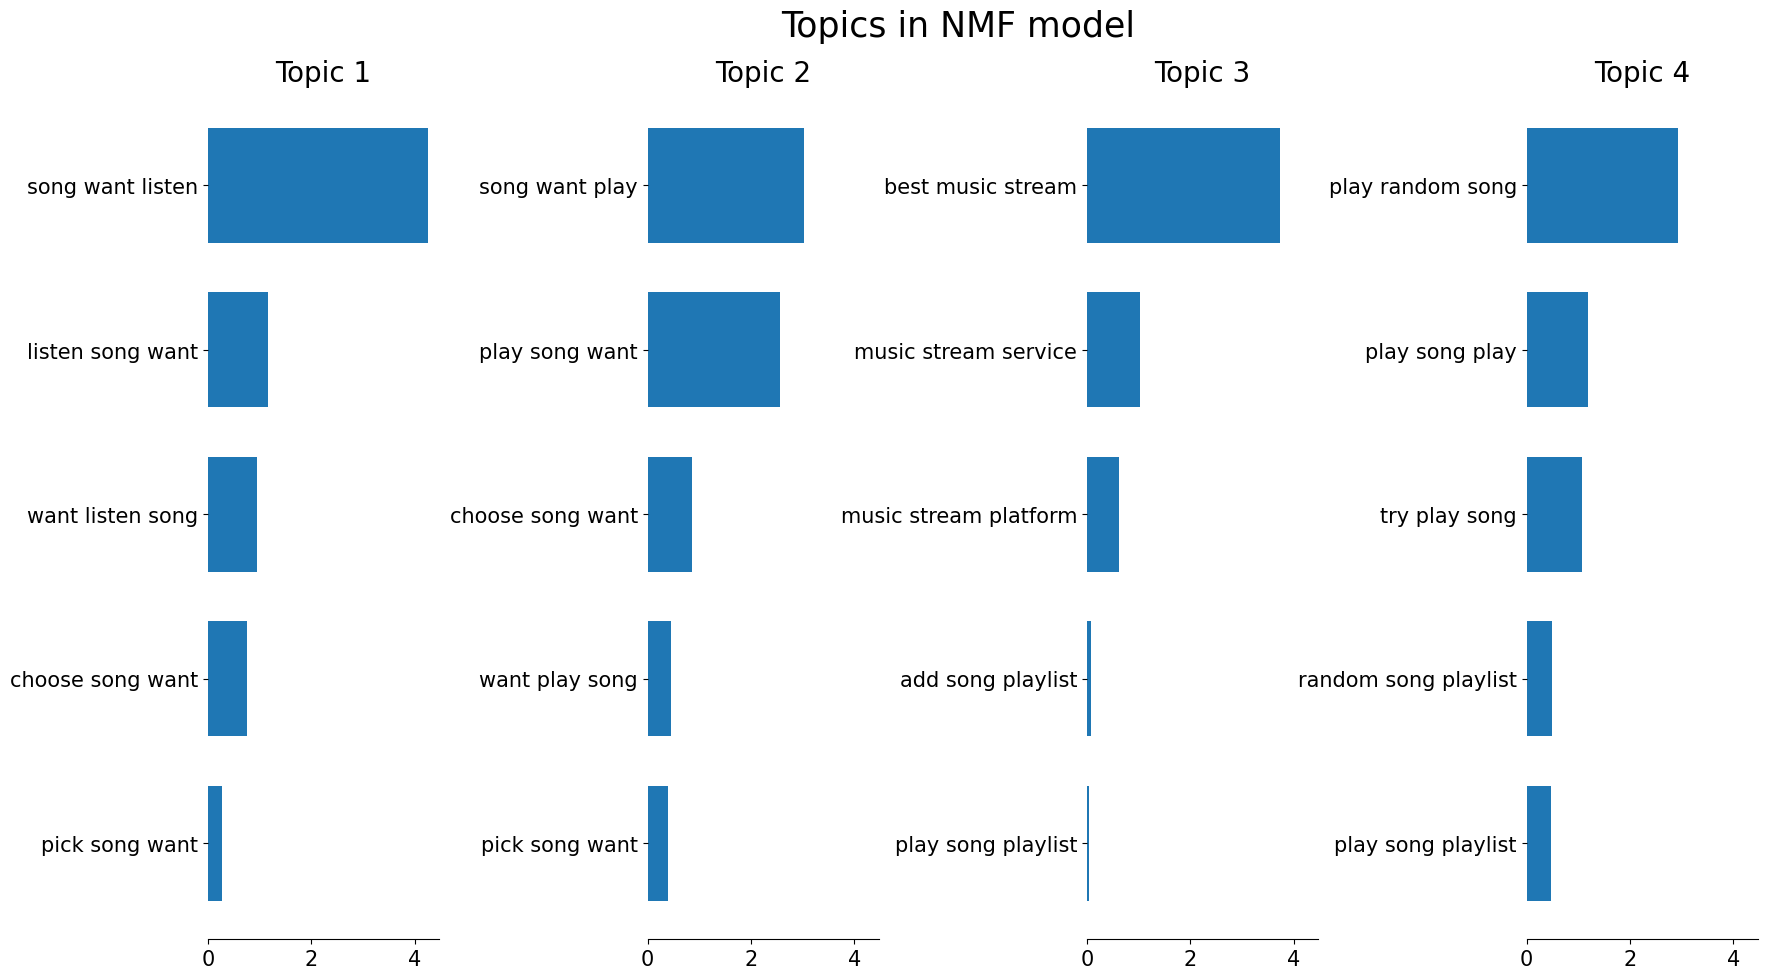

In [428]:
topic_word_plot()

In [371]:
pos_reviews.review.sample(1).values

array(["i have had it for about two weeks now and it's good, so far. listening to a lot of phil collins and dmx. yes, i like both!"],
      dtype=object)

In [370]:
tester_test = "botched everything up recently. please make it better or back to how it was."

In [368]:
TextBlob(tester_text).sentiment.polarity

0.125

### TSNE 

In [429]:
from sklearn.manifold import TSNE

In [444]:
tsne = TSNE(random_state=42, learning_rate=100)
tsnes_trans = tsne.fit_transform(H_pos)

In [459]:
tsnes_trans = pd.DataFrame(tsnes_trans, columns = ['TSNE1', 'TSNE2'])
tsnes_trans

,TSNE1,TSNE2
0,69.881432,51.420773
1,-20.720106,0.833096
2,-20.720106,0.833096
3,-20.720106,0.833096
4,-20.720106,0.833096
...,...,...
40060,-20.720106,0.833096
40061,78.596054,-20.771082
40062,83.647964,11.342211
40063,69.412254,-62.999954


In [453]:
import numpy as np

In [451]:
topic_name_dict = {0:'music library',1:'ux customization',2:'playlists',3:'algorithm'}

In [460]:
# for each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsnes_trans['class'] = np.argmax(H_pos, axis = 1)
tsnes_trans['class'] = tsnes_trans['class'].replace(topic_name_dict)

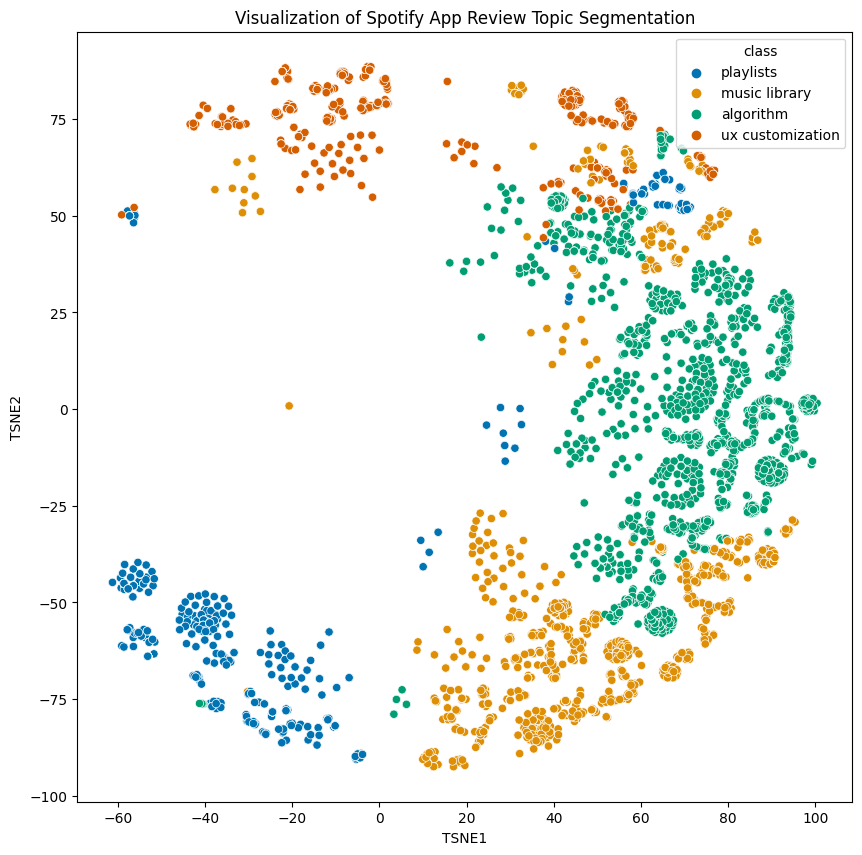

In [470]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsnes_trans, palette = 'colorblind')
plt.title('Visualization of Spotify App Review Topic Segmentation')
plt.show()

### Negative Reviews WordCloud

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


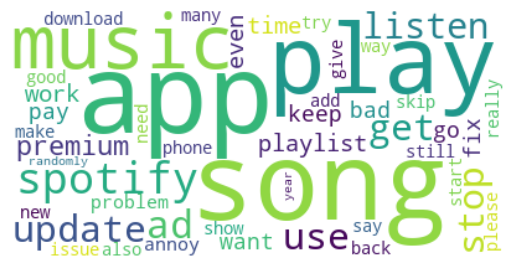

In [213]:
review_wordcloud(neg_reviews)

## Topic Modeling - Positive Reviews

In [438]:
X_train = vec.fit_transform(pos_reviews.tokens)

In [440]:
#X_vectorized = tfdif_vect.fit_transform(corpus.review)
#topic_model = NMF(n_components = 3)
#topic_model.fit(X_vectorized)
pos_rvs_tmdl = NMF(n_components=4)
pos_rvs_tmdl.fit(X_train)

NMF(n_components=4)

In [441]:
# to get H
H_pos = pos_rvs_tmdl.transform(X_train) # transform document into topic vector representation

# to get W 
W_pos = pos_rvs_tmdl.components_ # word component weights for each topic

In [443]:
for index,topic in enumerate(W_pos):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['listen music', 'want listen', 'best music', 'love music', 'easy use', 'great music', 'good music', 'many ad', 'free version', 'really good', 'favorite song', 'make playlist', 'pay premium', 'give star', 'new update', 'skip song', 'add song', 'song want', 'stop play', 'random song', 'play music', 'please fix', 'song playlist', 'song play', 'play song']


THE TOP 10 WORDS FOR TOPIC #1
['play song', 'listen song', 'add song', 'music stream', 'song playlist', 'song play', 'free version', 'new update', 'stop play', 'skip song', 'love music', 'random song', 'great music', 'favorite song', 'pay premium', 'good music', 'make playlist', 'really good', 'many ad', 'please fix', 'easy use', 'give star', 'play music', 'want listen', 'listen music']


THE TOP 10 WORDS FOR TOPIC #2
['random song', 'play song', 'listen music', 'listen song', 'stop play', 'skip song', 'song play', 'new update', 'please fix', 'favorite song', 'make playlist', 'add song', 'love music', 'ma

In [448]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W_pos):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 10
feature_names = vec.get_feature_names_out()
plot_top_words(W_pos, feature_names, n_top_words, "Topics in NMF model")

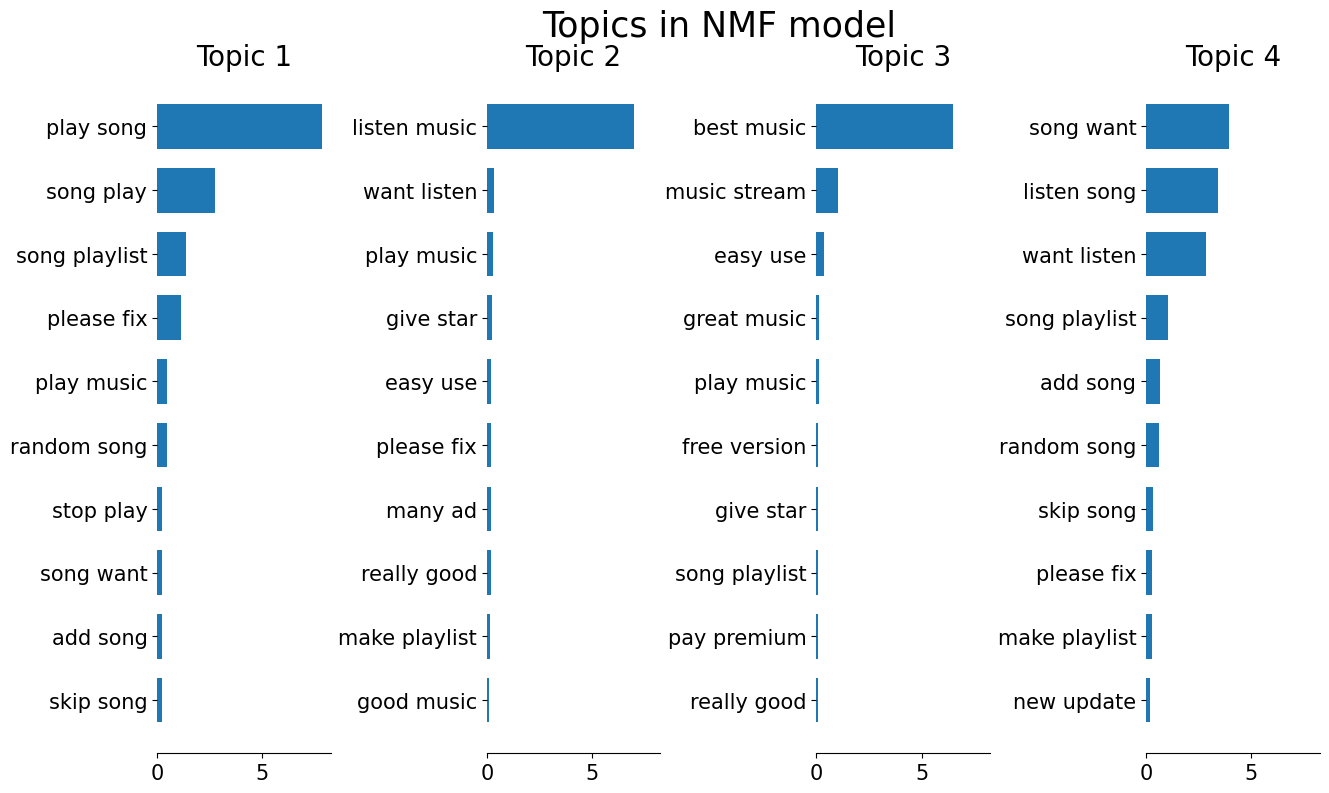

In [449]:
topic_word_plot()

Looks like people who leave positive reviews contain words such as 'music', 'song'. 

## IDK

In [40]:
first_review = corpus.iloc[1037].review

In [41]:
wordcloud = WordCloud()

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


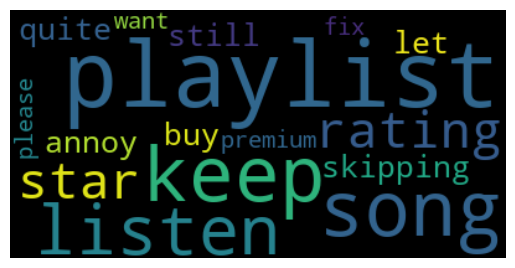

In [45]:
wordcloud.generate(first_review)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


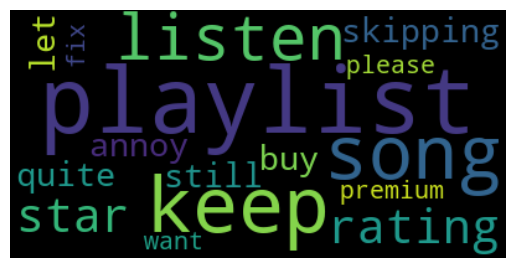

In [51]:
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords)
wordcloud.generate(first_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [54]:
spotify_df.review[1037]

"i'm rating this 2 stars whenever i keep skipping the song that is not in my playlist its still keeps letting me listen to another song that isn't in my playlist its quite annoying.. it's just i can't buy the premium but i want to listen to my own playlist so please fix it."

In [79]:
tfdif_vect.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [103]:
feature_names = tfdif_vect.get_feature_names_out()
dense = X_vectorized.todense()
X_list = dense.tolist()
X_df = pd.DataFrame(X_list, columns=feature_names)

In [107]:
X_frequencies = X_df.T.sum(axis=1)

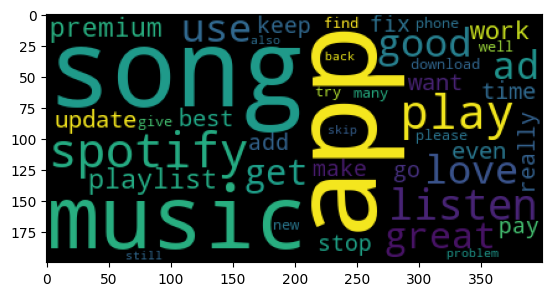

In [110]:
wordcloud.generate_from_frequencies(X_frequencies)

plt.imshow(wordcloud)

## IDK

In [55]:
spotify_df1 = spotify_df.drop(columns=['process_tok'])
df = pd.concat([spotify_df1,corpus], axis=1)

In [59]:
pos_reviews = df[df.sentiment.isin(['pos'])]
neg_reviews = df[df.sentiment.isin(['neg'])]

In [299]:
pos_reviews.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,process_tok
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,great music service audio high quality app eas...
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,please ignore previous negative rating app sup...
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,get best spotify experience android annoy plea...
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,dear spotify get song put playlist shuffle play
6,i love the selection and the lyrics are provid...,5,0,0,0.6696,0.257,0.000,pos,love selection lyric provide song listening


C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


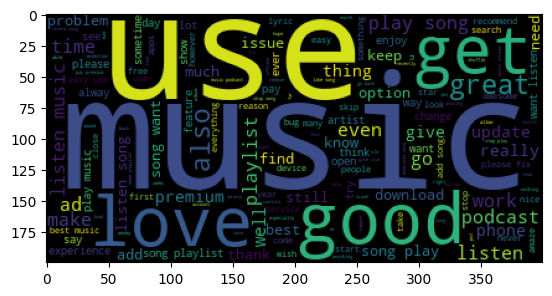

In [306]:
pos_text = ''.join(review for review in pos_reviews.process_tok)
wordcloud = WordCloud(stopwords=stop_words).generate(pos_text)

# displaying generated image 
plt.imshow(wordcloud)

In [300]:
neg_reviews.head()

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,process_tok
3,really buggy and terrible to use as of recently,1,1,0,-0.5209,0.000,0.296,neg,really buggy terrible use recently
5,the player controls sometimes disappear for no...,3,7,0,-0.1655,0.072,0.157,neg,player control sometimes disappear reason app ...
10,"love spotify, and usually this app is the best...",2,1,0,-0.8095,0.128,0.243,neg,love spotify usually app best others state con...
11,can't play spotify when on wifi,1,1,0,-0.2584,0.000,0.289,neg,play spotify wifi
13,worst app always says i'm offline and never sh...,1,1,0,-0.6808,0.000,0.337,neg,bad app always say offline never show song pod...


C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


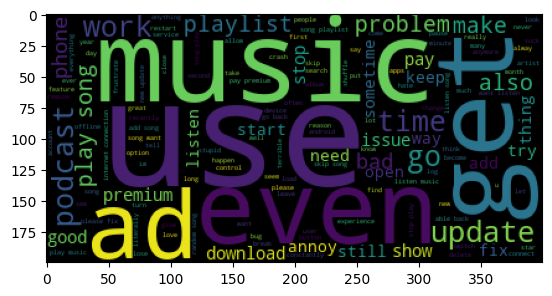

In [304]:
neg_text = ''.join(review for review in neg_reviews.process_tok)
wordcloud = WordCloud(stopwords=stop_words).generate(neg_text)

# displaying generated image 
plt.imshow(wordcloud)

In [161]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


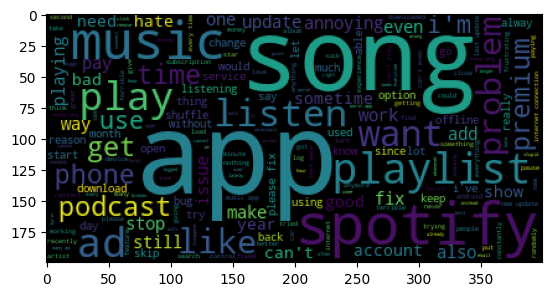

In [168]:
stop_words = stopwords.words('english')
text = ' '.join(review for review in neg_reviews.review)
wordcloud = WordCloud(stopwords=stop_words).generate(text)
plt.imshow(wordcloud)

In [171]:
new_stopwords = ['app','spotify']
stop_words.extend(new_stopwords)

In [192]:
import itertools

In [228]:
positive_reviews = spotify_df[spotify_df.sentiment.str.contains('pos')]
positive_reviews.process_tok[0]

"['great', 'music', 'service', 'audio', 'high', 'quality', 'app', 'easy', 'use', 'also', 'quick', 'friendly', 'support']"

In [234]:
# takes in untokenized document and returns fully normalized token list
def process_doc(doc):

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    # remove stop words and punctuations, then lower case
    doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
    doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
    
    return doc_norm

In [240]:
#positive_reviews = positive_reviews.drop(columns = ['process_tok'])

In [246]:
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging
from nltk.tokenize import word_tokenize 

In [248]:
positive_reviews['processed body'] = positive_reviews.review.apply(process_doc)
positive_reviews

,review,rating,total_thumbs_up,replied,comp_score,pos_score,neg_score,sentiment,processed body
0,"great music service, the audio is high quality...",5,2,0,0.9211,0.436,0.000,pos,"[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating. this a...,5,1,0,0.6249,0.404,0.243,pos,"[please, ignore, previous, negative, rating, s..."
2,"this pop-up ""get the best spotify experience o...",4,0,0,0.5859,0.258,0.107,pos,"[get, best, experience, android, annoy, please..."
4,dear spotify why do i get songs that i didn't ...,1,1,0,0.7149,0.260,0.000,pos,"[dear, get, song, put, playlist, shuffle, play]"
6,i love the selection and the lyrics are provid...,5,0,0,0.6696,0.257,0.000,pos,"[love, selection, lyric, provide, song, listen..."
...,...,...,...,...,...,...,...,...,...
61582,it selects music based on your taste makes bes...,5,4,0,0.8591,0.302,0.000,pos,"[selects, music, base, taste, make, best, mix,..."
61584,keeps putting songs i've hidden in my suggeste...,1,37,0,0.4749,0.071,0.029,pos,"[keep, put, song, hide, suggested, song, liste..."
61590,"use to be sooo good back when i had it, and wh...",1,0,0,0.8481,0.227,0.069,pos,"[use, sooo, good, back, download, free, versio..."
61592,the app is good hard to navigate and won't jus...,2,1,0,0.8074,0.159,0.023,pos,"[good, hard, navigate, let, play, song, click,..."


In [250]:
pos_reviews_toks = pd.Series(list(itertools.chain(*positive_reviews['processed body'])))
pos_reviews_toks

0           great
1           music
2         service
3           audio
4            high
           ...   
518356     diesnt
518357       work
518358       time
518359       work
518360      great
Length: 518361, dtype: object

In [254]:
# frequency distribution of most common tokens in positive reviews 
fdist = FreqDist(pos_reviews_toks)
fdist.most_common(10)

[('song', 20728),
 ('music', 19155),
 ('play', 11905),
 ('love', 8681),
 ('listen', 8676),
 ('good', 8040),
 ('use', 7504),
 ('great', 6761),
 ('playlist', 6400),
 ('ad', 6042)]

C:\Users\Kevin\anaconda3\envs\spotify-proj\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


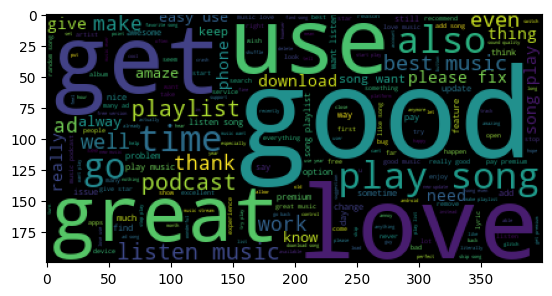

In [251]:
# word cloud for positive reviews 
text = ' '.join(review for review in pos_reviews_toks)
wordcloud = WordCloud(stopwords=stop_words).generate(text)
plt.imshow(wordcloud)

### Topic Modeling

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [87]:
tfdif_vect = TfidfVectorizer(min_df=0.05, max_df=0.95)

In [88]:
corpus = corpus.dropna()

In [89]:
X_vectorized = tfdif_vect.fit_transform(corpus.review)
topic_model = NMF(n_components = 3)
topic_model.fit(X_vectorized)

NMF(n_components=3)

In [90]:
# to get H
H = topic_model.transform(X_vectorized) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

In [91]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfdif_vect.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['even', 'pay', 'go', 'phone', 'many', 'also', 'make', 'keep', 'time', 'download', 'get', 'well', 'stop', 'work', 'find', 'really', 'love', 'use', 'ad', 'listen', 'good', 'best', 'great', 'app', 'music']


THE TOP 10 WORDS FOR TOPIC #1
['work', 'try', 'download', 'also', 'keep', 'premium', 'make', 'go', 'time', 'please', 'good', 'skip', 'stop', 'fix', 'get', 'update', 'add', 'even', 'ad', 'listen', 'want', 'app', 'playlist', 'play', 'song']


THE TOP 10 WORDS FOR TOPIC #2
['give', 'keep', 'problem', 'even', 'listen', 'new', 'back', 'well', 'still', 'try', 'please', 'make', 'phone', 'update', 'really', 'fix', 'go', 'pay', 'time', 'work', 'get', 'premium', 'use', 'love', 'spotify']




In [38]:
#vis = pyLDAvis.prepare(topic_model, X_vectorized, tfdif_vect)
#pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'nmf_topics.html')

TypeError: prepare() missing 2 required positional arguments: 'vocab' and 'term_frequency'

In [92]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W_pos):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 10
tfidf_feature_names = tfdif_vect.get_feature_names_out()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

NameError: name 'W_pos' is not defined

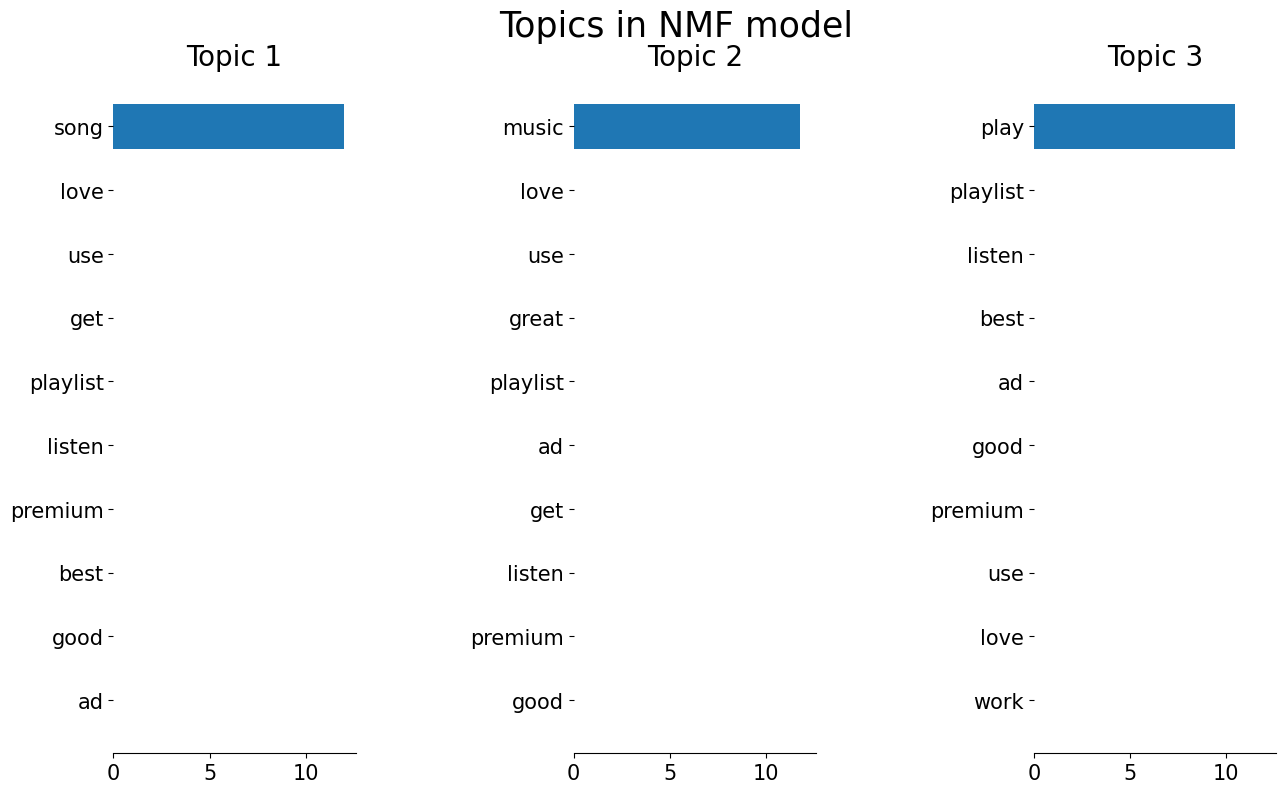

In [275]:
topic_word_plot()

## Vectorizing

In [141]:
#original datasets 
spotify_df
corpus

,process_tok
0,great music service audio high quality app eas...
1,please ignore previous negative rating app sup...
2,get best spotify experience android annoy plea...
3,really buggy terrible use recently
4,dear spotify get song put playlist shuffle play
...,...
61589,even communicate lyric feature available user ...
61590,use sooo good back download free version pick ...
61591,app good take device start comp spotify start ...
61592,app good hard navigate let play song click pla...


In [145]:
corpus = corpus.dropna()
corpus.isna().sum()

process_tok    0
dtype: int64

In [106]:
tfdif_vect = TfidfVectorizer()
X_vectorized = tfdif_vect.fit_transform(corpus.process_tok)

vec_tfidf = pd.DataFrame(X_vectorized.toarray(), columns=tfdif_vect.get_feature_names_out())
vec_tfidf.head()

,aa,aaa,aaaaaaaa,aaaannndd,aaah,aaahh,aac,aad,aada,aads,...,𝚊𝚙𝚙,𝚎𝚟𝚎𝚛,𝚑𝚊𝚟𝚎,𝚒𝚜,𝚕𝚘𝚟𝚎𝚍,𝚖𝚘𝚜𝚝,𝚖𝚞𝚜𝚒𝚌,𝚝𝚑𝚎,𝚝𝚑𝚒𝚗𝚔,𝚝𝚑𝚒𝚜
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
vec_tfidf.iloc[312].sort_values(ascending=False)[:10]

variety          0.693369
excellent        0.671449
music            0.261525
prompts          0.000000
pronunciation    0.000000
properly         0.000000
proper           0.000000
propagate        0.000000
propaganda       0.000000
prop             0.000000
Name: 312, dtype: float64

In [120]:
spotify_df.review[312]

'excellent music variety.'

In [131]:
topic_model = NMF(n_components = 5)
topic_model.fit(X_vectorized)

NMF(n_components=5)

In [132]:
# to get H
H = topic_model.transform(X_vectorized) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

In [133]:
H

array([[0.        , 0.04496429, 0.        , 0.01152763, 0.01128467],
       [0.00022301, 0.0181601 , 0.0007941 , 0.01570044, 0.        ],
       [0.0024236 , 0.01741554, 0.01149088, 0.02889251, 0.01654859],
       ...,
       [0.00591983, 0.00662924, 0.00417211, 0.04540426, 0.00348327],
       [0.07897326, 0.        , 0.01079198, 0.01653228, 0.        ],
       [0.01436823, 0.02134039, 0.00046892, 0.04530019, 0.        ]])

In [93]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfdif_vect.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['even', 'pay', 'go', 'phone', 'many', 'also', 'make', 'keep', 'time', 'download', 'get', 'well', 'stop', 'work', 'find', 'really', 'love', 'use', 'ad', 'listen', 'good', 'best', 'great', 'app', 'music']


THE TOP 10 WORDS FOR TOPIC #1
['work', 'try', 'download', 'also', 'keep', 'premium', 'make', 'go', 'time', 'please', 'good', 'skip', 'stop', 'fix', 'get', 'update', 'add', 'even', 'ad', 'listen', 'want', 'app', 'playlist', 'play', 'song']


THE TOP 10 WORDS FOR TOPIC #2
['give', 'keep', 'problem', 'even', 'listen', 'new', 'back', 'well', 'still', 'try', 'please', 'make', 'phone', 'update', 'really', 'fix', 'go', 'pay', 'time', 'work', 'get', 'premium', 'use', 'love', 'spotify']




In [96]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = tfdif_vect.get_feature_names_out()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

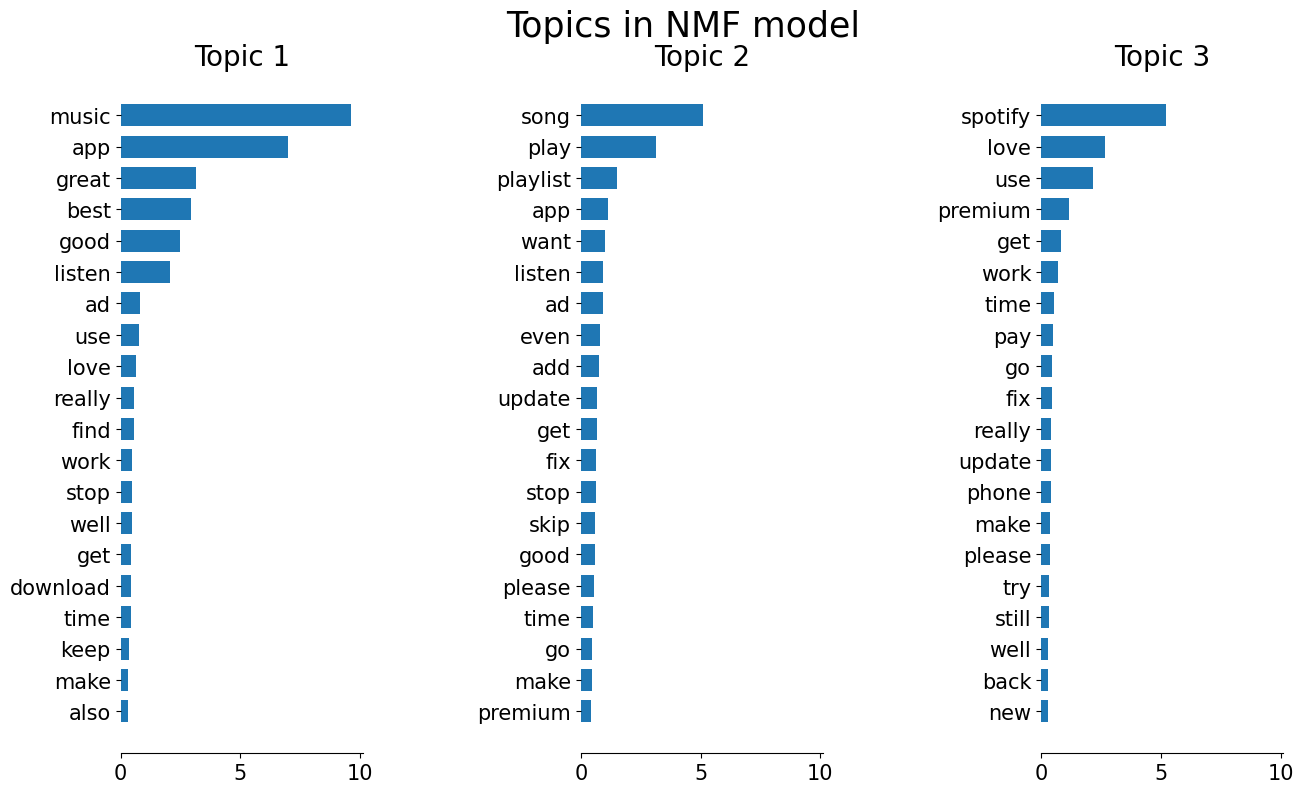

In [97]:
topic_word_plot()